![](img/573_banner.png)

# Lecture 4: Feature importances and feature selection 

UBC Master of Data Science program, 2022-23

Instructor: Varada Kolhatkar

## Imports and LOs

### Imports

In [1]:
import os
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("code/.")
import seaborn as sns
from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR
from utils import *

%matplotlib inline

### Learning outcomes 

From this lecture, students are expected to be able to:

- Explain the limitations of simple correlation-based approaches to identify feature importances.   
- Interpret the coefficients of linear regression, including for scaled numeric features. 
- Explain the purpose of feature selection. 
- Discuss and compare different feature selection methods at a high level. 
- Explain and use model-based feature selection. 
- Explain recursive feature elimination at a high level. 
- Use `sklearn`'s implementation of recursive feature elimination (`RFE`). 
- Explain how RFECV (cross-validated recursive feature elimination) works. 
- Explain forward and backward feature selection at a high level. 
- Use `sklearn`'s implementation of forward and backward selection. 

I'm using `seaborn` in this lecture for easy heatmap plotting, which is not in the course environment. You can install it as follows. 
```
> conda activate 573
> conda install -c anaconda seaborn
```

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data 

In the first part of this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), the dataset we used in lecture 10. As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [3]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The prediction task is predicting `SalePrice` given features related to properties.  
- Note that the target is numeric, not categorical.

In [4]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [5]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### Let's identify feature types

In [6]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [7]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [8]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ["NA", "No", "Mn", "Av", "Gd"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
]

In [9]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['LotConfig',
 'Alley',
 'MiscFeature',
 'LotShape',
 'RoofStyle',
 'Electrical',
 'Foundation',
 'RoofMatl',
 'Exterior2nd',
 'Exterior1st',
 'LandContour',
 'Utilities',
 'MasVnrType',
 'SaleCondition',
 'CentralAir',
 'MoSold',
 'Condition2',
 'BldgType',
 'GarageType',
 'GarageFinish',
 'LandSlope',
 'HouseStyle',
 'MSZoning',
 'Condition1',
 'Neighborhood',
 'MSSubClass',
 'PavedDrive',
 'Street',
 'Heating',
 'SaleType']

In [10]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

In [11]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [12]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
new_columns = (
    numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns
)

In [13]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.372763,-0.222647,-0.025381,-0.127107,-0.054669,2.184405,-0.165485,0.743555,0.843281,-0.090231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1122,0.154795,-0.222647,-0.025381,-0.149788,-1.491366,-2.310284,-0.496757,-1.389065,-0.573129,-0.961498,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1346,0.154795,-0.222647,-0.025381,1.168244,0.663680,1.285467,-0.099230,0.888961,-0.573129,-0.314582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1406,-1.063173,-0.222647,0.022331,-0.203265,-0.773017,1.285467,0.033279,1.082835,-0.573129,0.467379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
X_train_enc.shape

(1314, 263)

In [15]:
lr_pipe = make_pipeline(preprocessor, Ridge())
scores = cross_validate(lr_pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.037688,0.006314,0.834450,0.916827
1,0.033185,0.006056,0.810031,0.919218
2,0.018007,0.004891,0.831653,0.912397
3,0.020183,0.004715,0.843537,0.914043
4,0.017457,0.004584,0.548802,0.920476


<br><br><br><br>

## Feature importances

- How does the output depend upon the input? 
- How do the predictions change as a function of a particular feature?
- If the model is bad interpretability does not make sense. 

### SimpleFeature correlations

- Let's look at the correlations between various features with other features and the target in our encoded data (first row/column). 
- In simple terms here is how you can interpret correlations between two variables $X$ and $Y$:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

Let's examine the correlations among different columns, including the target column. 

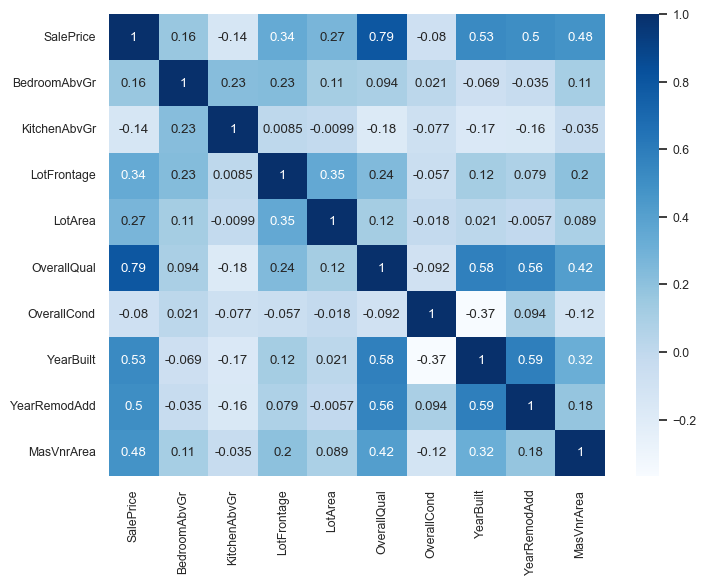

In [16]:
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, :10].corr()
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

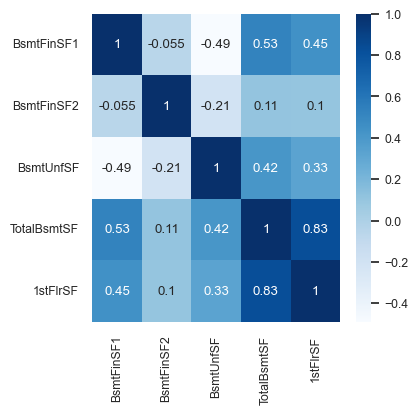

In [17]:
cor = pd.concat((y_train, X_train_enc), axis=1).iloc[:, 10:15].corr()
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

<br><br>

### Feature importances in linear models 

- With linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.

In [18]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

Let's look at the coefficients. 

In [19]:
lr_coefs = pd.DataFrame(
    data=lr.named_steps["ridge"].coef_, index=new_columns, columns=["Coefficient"]
)
lr_coefs.head(20)

,Coefficient
BedroomAbvGr,-3723.741570
KitchenAbvGr,-4580.204576
LotFrontage,-1578.664421
LotArea,5109.356718
OverallQual,12487.561839
OverallCond,4855.535334
YearBuilt,4226.684842
YearRemodAdd,324.664715
MasVnrArea,5251.325210
BsmtFinSF1,3667.172851


Let's try to interpret coefficients for different types of features. 

### Ordinal features

- The ordinal features are easiest to interpret. 

In [20]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [21]:
lr_coefs.loc["ExterQual"]

Coefficient    4195.671512
Name: ExterQual, dtype: float64

- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.
  - Wow, that's a lot! 
  - Remember this is just what the model has learned. It doesn't tell us how the world works. 

In [22]:
one_example = X_test[:1]

In [23]:
one_example[["ExterQual"]]

,ExterQual
147,Gd


Let's perturb the example and change `ExterQual` to `Ex`. 

In [24]:
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = "Ex"  # Change Gd to Ex

In [25]:
one_example_perturbed[["ExterQual"]]

,ExterQual
147,Ex


How does the prediction change after changing `ExterQual` from `Gd` to `Ex`? 

In [26]:
print("Prediction on the original example: ", lr.predict(one_example))
print("Prediction on the perturbed example: ", lr.predict(one_example_perturbed))
print(
    "After changing ExterQual from Gd to Ex increased the prediction by: ",
    lr.predict(one_example_perturbed) - lr.predict(one_example),
)

Prediction on the original example:  [224795.63596803]
Prediction on the perturbed example:  [228991.30748049]
After changing ExterQual from Gd to Ex increased the prediction by:  [4195.67151247]


That's exactly the learned coefficient for `ExterQual`! 

In [27]:
lr_coefs.loc["ExterQual"]

Coefficient    4195.671512
Name: ExterQual, dtype: float64

So our interpretation is correct! 
- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by $\sim\$4195$.

<br><br>

### Categorical features

- What about the categorical features?
- We have created a number of columns for each category with OHE and each category gets it's own coefficient. 

In [28]:
print(categorical_features)

['LotConfig', 'Alley', 'MiscFeature', 'LotShape', 'RoofStyle', 'Electrical', 'Foundation', 'RoofMatl', 'Exterior2nd', 'Exterior1st', 'LandContour', 'Utilities', 'MasVnrType', 'SaleCondition', 'CentralAir', 'MoSold', 'Condition2', 'BldgType', 'GarageType', 'GarageFinish', 'LandSlope', 'HouseStyle', 'MSZoning', 'Condition1', 'Neighborhood', 'MSSubClass', 'PavedDrive', 'Street', 'Heating', 'SaleType']


In [29]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,457.197456
LandSlope_Mod,7420.208381
LandSlope_Sev,-7877.405837


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [30]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,6963.010925
LandSlope_Sev,-8334.603292


- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$6963$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8334$


Note that this might not make sense in the real world but this is what our model decided to learn given this small amount of data. 

In [101]:
one_example = X_test[:1]
one_example[['LandSlope']]

,LandSlope
147,Gtl


Let's perturb the example and change `LandSlope` to `Mod`. 

In [102]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LandSlope"] = "Mod"  # Change Gd to Ex

In [103]:
one_example_perturbed[["LandSlope"]]

,LandSlope
147,Mod


How does the prediction change after changing `LandSlope` from `Gtl` to `Mod`? 

In [104]:
print("Prediction on the original example: ", lr.predict(one_example))
print("Prediction on the perturbed example: ", lr.predict(one_example_perturbed))
print(
    "After changing ExterQual from Gd to Ex increased the prediction by: ",
    lr.predict(one_example_perturbed) - lr.predict(one_example),
)

Prediction on the original example:  [224795.63596803]
Prediction on the perturbed example:  [231758.64689313]
After changing ExterQual from Gd to Ex increased the prediction by:  [6963.0109251]


Our interpretation above is correct! 

In [31]:
lr_coefs.sort_values(by="Coefficient")

,Coefficient
RoofMatl_ClyTile,-191129.774314
Condition2_PosN,-105552.840565
Heating_OthW,-27260.681308
MSZoning_C (all),-21990.746193
Exterior1st_ImStucc,-19393.964621
...,...
PoolQC,34217.656047
RoofMatl_CompShg,36525.980874
Neighborhood_NridgHt,37532.643270
Neighborhood_StoneBr,39993.978324


- For example, the above coefficient says that "If the roof is made of clay or tile, the predicted price is \\$191K less"?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 

```{note}
If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one. The interpretation depends on whether we did `drop='first'`, hence the hassle.
```

<br><br>

### Interpreting coefficients of numeric features

Let's look at coefficients of `PoolArea`, `LotFrontage`, `LotArea`. 

In [32]:
lr_coefs.loc[["PoolArea", "LotFrontage", "LotArea"]]

,Coefficient
PoolArea,2822.370476
LotFrontage,-1578.664421
LotArea,5109.356718


Intuition: 

- Tricky because numeric features are **scaled**! 
- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$2822$.
- **Increasing** `LotArea` by 1 scaled unit **increases** the predicted price by $\sim\$5109$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1578$.

Does that sound reasonable?

- For `PoolArea` and `LotArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?

It might be the case that `LotFrontage` is correlated with some other variable, which might have a larger positive coefficient. 

BTW, let's make sure the predictions behave as expected:

#### Example showing how can we interpret coefficients of scaled features. 

- What's one scaled unit for `LotArea`? 
- The scaler subtracted the mean and divided by the standard deviation.
- The division actually changed the scale! 
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [33]:
scaler = preprocessor.named_transformers_["pipeline-1"]["standardscaler"]

In [34]:
lr_scales = pd.DataFrame(
    data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"]
)
lr_scales.head()

,Scale
BedroomAbvGr,0.821040
KitchenAbvGr,0.218760
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082


- It seems like `LotArea` was divided by 8994.471032 sqft. 

In [35]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- The coefficient tells us that if we increase the **scaled** `LotArea` by one scaled unit the price would go up by $\approx\$5109$. 
- One scaled unit represents $\sim 8994$ sqft in the original scale. 

Let's examine whether this behaves as expected. 

In [36]:
X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test), index=X_test.index, columns=new_columns
)

In [37]:
one_ex_preprocessed = X_test_enc[:1]
one_ex_preprocessed

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
147,0.154795,-0.222647,-0.025381,-0.085415,0.66368,-0.512408,0.993969,0.792023,0.438592,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
orig_pred = lr.named_steps["ridge"].predict(one_ex_preprocessed)
orig_pred

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


array([224795.63596803])

In [39]:
one_ex_preprocessed_perturbed = one_ex_preprocessed.copy()
one_ex_preprocessed_perturbed["LotArea"] += 1  # we are adding one to the scaled LotArea
one_ex_preprocessed_perturbed

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Heating_Wall,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
147,0.154795,-0.222647,-0.025381,0.914585,0.66368,-0.512408,0.993969,0.792023,0.438592,-0.961498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We are expecting an increase of $5109.35671809 in the prediction compared to the original value of `LotArea`. 

In [40]:
perturbed_pred = lr.named_steps["ridge"].predict(one_ex_preprocessed_perturbed)

/Users/kvarada/opt/miniconda3/envs/573/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [41]:
perturbed_pred - orig_pred

array([5109.35671809])

Our interpretation is correct! 

- Humans find it easier to think about features in their original scale.  
- How can we interpret this coefficient in the original scale? 
- If I increase original `LotArea` by one square foot then the predicted price would go up by this amount: 

In [42]:
5109.356718094072 / 8994.471032 # Coefficient learned on the scaled features / the scaling factor for this feature

0.5680552752814816

In [43]:
one_example = X_test[:1]

In [44]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Let's perturb the example and add 1 to the `LotArea`. 

In [45]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1

if we add 8994.471032 to the original LotArea, the housing price prediction should go up by the coefficient 5109.35671794. 

In [46]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Prediction on the original example. 

In [47]:
lr.predict(one_example)

array([224795.63596803])

Prediction on the perturbed example. 

In [48]:
lr.predict(one_example_perturbed)

array([224796.2040233])

- What's the difference between predictions? 
- Does the difference make sense given the coefficient of the feature? 

In [49]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.56805528])

Yes! Our interpretation is correct. 

- That said don't read too much into these coefficients without statistical training. 

### Interim summary

- Correlation among features might make coefficients completely uninterpretable. 
- Fairly straightforward to interpret coefficients of ordinal features. 
- In categorical features, it's often helpful to consider one category as a reference point and think about relative importance. 
- For numeric features, relative importance is meaningful after scaling.
- You have to be careful about the scale of the feature when interpreting the coefficients. 
- Remember that explaining the model $\neq$ explaining the data or explaining how the world works.  
- The coefficients tell us only about the model and they might not accurately reflect the data. 

<br><br><br><br>

## Feature selection: Introduction and motivation 


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 


### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at a few automatic feature selection methods.
    - Model-based selection 
    - Recursive feature elimination
    - Forward/Backward selection 
- Very related to looking at feature importances.

In [50]:
results = {}

Let's start with the dummy model. 

We'll be using the user-defined function `mean_std_cross_val_scores` to keep track of the results. You can find the code of the function in `code/utils.py`. 

In [51]:
results["dummy"] = mean_std_cross_val_scores(
    DummyRegressor(), X_train, y_train, return_train_score=True
)

Let's try `Ridge` without any feature selection. 

In [52]:
pipe_lr = make_pipeline(preprocessor, Ridge())

results["ridge"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True
)

In [53]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.005 (+/- 0.006),0.000 (+/- 0.000)
ridge,0.022 (+/- 0.006),0.005 (+/- 0.001),0.774 (+/- 0.126),0.917 (+/- 0.003)


Now let's try `RandomForestRegressor`. 

_We have not talked about this model yet. At this point it's enough to know that it's a tree-based model which is a good off-the-shelf model. We'll be talking about it in Week 4._

In [54]:
pipe_rf = make_pipeline(preprocessor, RandomForestRegressor())

results["rf"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train, return_train_score=True
)

In [55]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.005 (+/- 0.006),0.000 (+/- 0.000)
ridge,0.022 (+/- 0.006),0.005 (+/- 0.001),0.774 (+/- 0.126),0.917 (+/- 0.003)
rf,1.004 (+/- 0.006),0.010 (+/- 0.001),0.855 (+/- 0.032),0.979 (+/- 0.001)


Now we'll try a number of feature selection methods and compare the results with the scores above. 

## Break (5 min)

![](img/eva-coffee.png)

<br><br><br><br>

## Feature selection using feature importances

### Model-based feature selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important once. 
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

Let's examine the least important features according to the model (features associated with coefficients with small magnitude). 

In [56]:
pipe_lr.fit(X_train, y_train);

In [57]:
data = {
    "coefficient": pipe_lr.named_steps["ridge"].coef_.tolist(),
    "magnitude": np.absolute(pipe_lr.named_steps["ridge"].coef_),
}
coef_df = pd.DataFrame(data, index=new_columns).sort_values("magnitude")
coef_df

,coefficient,magnitude
BsmtFinType2,-5.674533,5.674533
GarageArea,109.408190,109.408190
HouseStyle_SFoyer,110.057530,110.057530
MiscFeature_missing,-144.483323,144.483323
SaleCondition_Alloca,-147.260030,147.260030
...,...,...
Neighborhood_NridgHt,37532.643270,37532.643270
Neighborhood_StoneBr,39993.978324,39993.978324
RoofMatl_WdShngl,83646.711008,83646.711008
Condition2_PosN,-105552.840565,105552.840565


- Seems like there are a number of features with tiny coefficients compared to other features. 
- These features are not going to have a big impact on the prediction. 

In [58]:
coefs = (
    pd.DataFrame(pipe_lr.named_steps["ridge"].coef_, new_columns, columns=["coef"])
    .query("coef != 0")
    .sort_values("coef")
    .reset_index()
    .rename(columns={"index": "variable"})
)
# coefs.style.background_gradient('PuOr')

Let's examine the coefficients. 

In [59]:
import altair as alt

alt.Chart(
    coefs,
    title=pipe_lr.named_steps["ridge"].__str__()[:-2] + " Coefficients",
).mark_bar().encode(y=alt.Y("variable", sort="x"), x="coef")

alt.Chart(...)

- How about getting rid of some of these features? 
    - That's the idea of Model-based feature selection. 
- How do we use model-based selection?
    - Decide a threshold. 
    - Discard all features whose feature importances / coefficients are smaller than the threshold.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `Ridge` for feature selection with threshold "median" of feature importances. 
- Approximately how many features will be selected? 

In [60]:
from sklearn.feature_selection import SelectFromModel

select_lr = SelectFromModel(Ridge(), threshold="median")

- We can put the feature selection transformer in a pipeline. 
- Should we put it before preprocessing or after preprocessing? 

In [61]:
pipe_rf_model_based = make_pipeline(
    preprocessor, select_lr, RandomForestRegressor(random_state=42)
)  # Feature selection with Ridge and final estimator is RandomForestRegressor

results["model_based_fs + rf"] = mean_std_cross_val_scores(
    pipe_rf_model_based, X_train, y_train, return_train_score=True
)

In [62]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.005 (+/- 0.006),0.000 (+/- 0.000)
ridge,0.022 (+/- 0.006),0.005 (+/- 0.001),0.774 (+/- 0.126),0.917 (+/- 0.003)
rf,1.004 (+/- 0.006),0.010 (+/- 0.001),0.855 (+/- 0.032),0.979 (+/- 0.001)
model_based_fs + rf,0.463 (+/- 0.042),0.010 (+/- 0.000),0.847 (+/- 0.038),0.978 (+/- 0.001)


In [63]:
pipe_rf_model_based.fit(X_train, y_train);

How many features were passed to feature selection? 

In [64]:
pipe_rf_model_based.named_steps["selectfrommodel"].n_features_in_

263

What's the threshold used for feature selection? 

In [65]:
pipe_rf_model_based.named_steps["selectfrommodel"].threshold_

4855.535333685491

How many and which features are selected? 

In [66]:
def show_selected_feature_mask(mask):
    # visualize the mask. yellow is True, blue is False
    plt.matshow(mask.reshape(1, -1), cmap="viridis")
    plt.xlabel("Feature index")
    plt.yticks(());

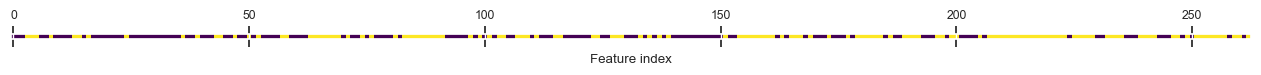

In [67]:
model_based_mask = pipe_rf_model_based.named_steps["selectfrommodel"].get_support()
show_selected_feature_mask(model_based_mask)

In [68]:
mb_selected_feats = X_train_enc.columns[model_based_mask]
mb_selected_feats.shape

(132,)

In [69]:
coef_df

,coefficient,magnitude
BsmtFinType2,-5.674533,5.674533
GarageArea,109.408190,109.408190
HouseStyle_SFoyer,110.057530,110.057530
MiscFeature_missing,-144.483323,144.483323
SaleCondition_Alloca,-147.260030,147.260030
...,...,...
Neighborhood_NridgHt,37532.643270,37532.643270
Neighborhood_StoneBr,39993.978324,39993.978324
RoofMatl_WdShngl,83646.711008,83646.711008
Condition2_PosN,-105552.840565,105552.840565


BsmtFinType2 feature with a coefficient of smallest magnitude is not selected. 

In [70]:
"BsmtFinType2" in mb_selected_feats

False

- About half of the features are selected because our threshold is median. 
- We are getting similar results using only half of the features, i.e., with 132 features instead of 263 features!! 

In [71]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.005 (+/- 0.006),0.000 (+/- 0.000)
ridge,0.022 (+/- 0.006),0.005 (+/- 0.001),0.774 (+/- 0.126),0.917 (+/- 0.003)
rf,1.004 (+/- 0.006),0.010 (+/- 0.001),0.855 (+/- 0.032),0.979 (+/- 0.001)
model_based_fs + rf,0.463 (+/- 0.042),0.010 (+/- 0.000),0.847 (+/- 0.038),0.978 (+/- 0.001)


<br><br>

### Recursive feature elimination (RFE)

- Similar to model-based selection, 
- Based on feature importances
- But it's different in the sense that it **iteratively** eliminates unimportant features.   
- It builds a series of models. At each iteration, discards the least important feature according to the model. 
- Computationally expensive

### RFE algorithm 

1. Decide the number of features to select. 
2. **Assign** importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. **Remove** the least important feature.
4. **Repeat** steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!

How do we use it? 

In [72]:
from sklearn.feature_selection import RFE

rfe = RFE(Ridge(), n_features_to_select=120)

pipe_rf_rfe = make_pipeline(preprocessor, rfe, RandomForestRegressor(random_state=42))

results["rfe + rfe"] = mean_std_cross_val_scores(
    pipe_rf_rfe, X_train, y_train, return_train_score=True
)

In [73]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.005 (+/- 0.006),0.000 (+/- 0.000)
ridge,0.022 (+/- 0.006),0.005 (+/- 0.001),0.774 (+/- 0.126),0.917 (+/- 0.003)
rf,1.004 (+/- 0.006),0.010 (+/- 0.001),0.855 (+/- 0.032),0.979 (+/- 0.001)
model_based_fs + rf,0.463 (+/- 0.042),0.010 (+/- 0.000),0.847 (+/- 0.038),0.978 (+/- 0.001)
rfe + rfe,0.821 (+/- 0.042),0.010 (+/- 0.000),0.861 (+/- 0.038),0.980 (+/- 0.002)


Slightly better results with less features! 

In [74]:
pipe_rf_rfe.fit(X_train, y_train);

How many features are selected?

In [75]:
pipe_rf_rfe.named_steps["rfe"].n_features_

120

- What's the ranking of the selected features? 
- Selected features have a rank of 1. 

In [76]:
pipe_rf_rfe.named_steps["rfe"].ranking_

array([ 13,   5,  79,   1,   1,   1,   1, 133,   1,  39, 116,   1,   1,
         1,   1, 123,   1,  66, 122,  72,  86,  12,  59, 126,   1, 143,
        95, 139, 129,  81,  77,  53, 136, 131,   1,  52,   1, 138, 113,
         1, 110,  17, 115,   1,   1, 100, 144,   8,  83,  74,   1,   1,
         1,  73, 112,  51, 114,   1,   6, 107, 108, 141,   1,   1,   1,
         1,   1,   1,   1,   1, 109,   1,  55,  54,   1,  30,  45,  76,
        93,  38,  36,  37,  44,   1,   1,   1,   1,   1,   1,   1,   1,
         1, 132,  99, 102, 104,  48,   1,  90,   1,  15,   1, 103,   1,
         1,  47,  50,   1,  18,   1, 137,   1,  58,   7,  91,   1,  14,
        96,  71, 101,  98,  97,  11,   1,   1,   9,  75,   1,   1,   1,
         1,  78,  85,  46, 124,   1, 140,   1,  31,   1, 127, 135, 105,
         1,  80, 106,  68, 119,  67,   1, 118,   1, 117,  41,   1,   1,
         1,   1,   1,   1,   1,   1,  65,   2,  27,   1,   1,   1,  70,
         1,  57,  16, 111,   1,   1,  49,  87,   1, 120,   1,   

What features are selected? 

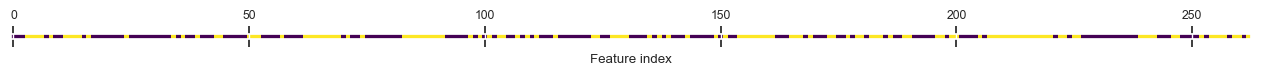

In [77]:
rfe_mask = pipe_rf_rfe.named_steps["rfe"].support_
show_selected_feature_mask(rfe_mask)

- Let's compare the selected features with features selected with model-based selection.  

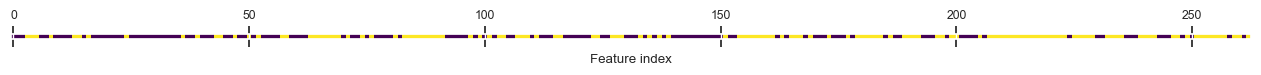

In [78]:
show_selected_feature_mask(model_based_mask)

It seems like there is some overlap between selected features between the two methods but they are not exactly the same. 

### Feature selection and categorical features 

- What about categorical features? 
- What if it removes one of the one-hot encoded feature and keeps other columns?
- Does it make sense? 
- This seems to be unresolved in sklearn: https://github.com/scikit-learn/scikit-learn/issues/8480

In [79]:
[
    col for col in X_train_enc.columns if col.startswith("BldgType")
]  # All OHE features for the BldgType categorical feature

['BldgType_1Fam',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE']

In [80]:
removed_columns = [
    col for col in X_train_enc.columns if col not in X_train_enc.columns[rfe_mask]
]
[
    col for col in removed_columns if col.startswith("BldgType")
]  # removed features for the BldgType categorical feature

['BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex']

### (Optional) Feature selection and OHE

- If you are using OHE with `drop='first'`, and then feature selection, the choice to drop the first is no longer arbitrary.
  - Say you have categories A,B,C,D
  - you drop='first'
  - so then you have B,C,D and 0,0,0 means A.
  - Then you feature select out D
  - Now you have B,C
  - but now 0,0 means A or D.
  - So now the feature removed by feature selection becomes mixed up with the "arbitrary" feature A.

<br><br>

### RFE with cross-validation (RFECV)

- We arbitrarily picked 120 features before. 
- How do we know what value to pass to `n_features_to_select`?
- Use `RFECV` which uses cross-validation to select number of features. 
- Slow because there is cross validation within cross validation 

In [81]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(Ridge())

pipe_rf_rfecv = make_pipeline(
    preprocessor, rfecv, RandomForestRegressor(random_state=42)
)
pipe_rf_rfecv.fit(X_train, y_train);

In [82]:
pipe_rf_rfecv

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'Bs...
                                                   'LandContour', 'Utilities',
                                                   'MasVnrType',
                                                   'SaleCondition',
                                                   'CentralAir', 'MoSold',
                                                   'Condition2', 'BldgType',
                                                   'GarageType', 'GarageFinish',
                                                   'LandSlope', 'HouseStyle',
                                                   'MSZoning', 'Condition1',
                                                   'Neighborhood', 'MSSubClass',
                                                   'PavedDrive', 'Street',
                                                   'Heating', 'SaleType'])])),
                ('rfecv', RFECV(estimator=Ridge())),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [83]:
rfecv_fs = pipe_rf_rfecv.named_steps["rfecv"]
rfecv_fs.n_features_

73

Let's examine the difference between the features selected by RFECV vs RFE with 120 features. 

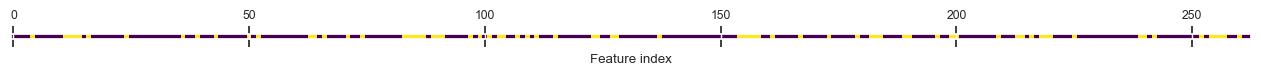

In [84]:
mask = pipe_rf_rfecv.named_steps["rfecv"].support_
show_selected_feature_mask(mask)

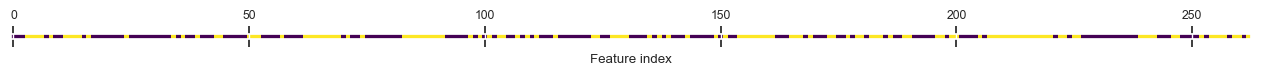

In [85]:
pipe_rf_rfe.fit(X_train, y_train)
mask = pipe_rf_rfe.named_steps["rfe"].support_
show_selected_feature_mask(mask)

Are we improving the final scores with RFECV? 

In [86]:
pipe_rf_rfecv = make_pipeline(
    preprocessor, rfecv, RandomForestRegressor(random_state=42)
)

results["rf+rfecv"] = mean_std_cross_val_scores(
    pipe_rf_rfecv, X_train, y_train, return_train_score=True
)

In [87]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.005 (+/- 0.006),0.000 (+/- 0.000)
ridge,0.022 (+/- 0.006),0.005 (+/- 0.001),0.774 (+/- 0.126),0.917 (+/- 0.003)
rf,1.004 (+/- 0.006),0.010 (+/- 0.001),0.855 (+/- 0.032),0.979 (+/- 0.001)
model_based_fs + rf,0.463 (+/- 0.042),0.010 (+/- 0.000),0.847 (+/- 0.038),0.978 (+/- 0.001)
rfe + rfe,0.821 (+/- 0.042),0.010 (+/- 0.000),0.861 (+/- 0.038),0.980 (+/- 0.002)
rf+rfecv,3.047 (+/- 0.426),0.010 (+/- 0.001),0.841 (+/- 0.069),0.950 (+/- 0.064)


How many features are selected?

In [88]:
pipe_rf_rfecv.named_steps["rfecv"].n_features_

73

Let's examine number of features selected and corresponding cross-validation scores. 

Optimal number of features : 73


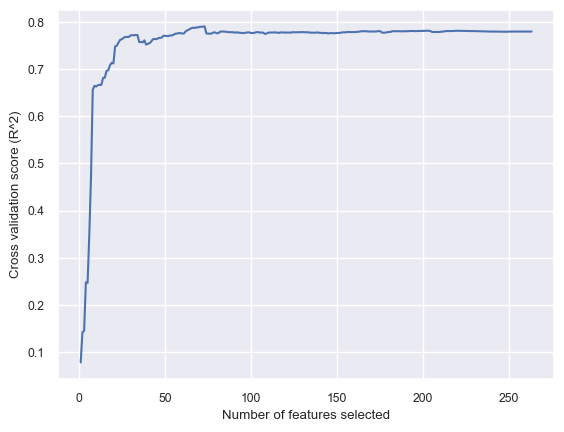

In [89]:
min_features_to_select = 1  # Minimum number of features to consider
pipe_rfecv = make_pipeline(
    preprocessor,
    RFECV(estimator=Ridge(), step=1, min_features_to_select=min_features_to_select),
)
pipe_rfecv.fit(X_train, y_train)
plot_cross_validated_rfe(pipe_rfecv)

- Our model is giving us the best results at number of features = 73. 
- But in our case when we pass these 73 selected features to `RandomForestRegressor`, which is a non-linear model, the scores get worse compared to 120 features or model-based selection. That said, we have reduced the dimensionality a lot.
- This is similar to using cross-validation to tune a hyperparameter.
- Indeed, the number of selected features is a hyperparameter.

### `sklearn` `feature_importances_`

- Do we have to use Ridge for feature selection? 
- Many `sklearn` models have `feature_importances_` attribute.
- For tree-based models it's calculated based on impurity (gini index or information gain).
- For example, you can use `RandomForestClassifier` for feature selection. It will use `feature_importances_` attribute instead of coefficients. 

<br><br>

## Search and score methods 
- Not based on feature importances.
- Can work for models which do not have feature importances. 
- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

### General idea of search and score methods 

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out? 
- This is intractable. So we go with greedy search methods such as forward or backward selection. 

### Forward or backward selection 

- Also called wrapper methods
- Shrink or grow feature set by removing or adding one feature at a time 
- Makes the decision based on whether adding/removing the feature improves the CV score or not

Given $X = \{x_1, x_2, \dots, x_n\}$ and $y$

1. Start with an empty set of features $S = \{\}$ 
2. Initialize the score (e.g., score = $\infty$, if score is validation error)
3. For each possible feature $x_j, 1\leq j \leq n$ 
    - Compute the scores of features in $S$ combined with $x_j$
4. If no $x_j$ improves the score or desired number of selected features is reached, stop. 
5. Otherwise add feature $x_j$ to $S$ which improves the score the most, update the score, and go back to step 2. 

How do we use these methods in `sklearn`? 

In [90]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_forward = make_pipeline(
    preprocessor,
    SequentialFeatureSelector(Ridge(), direction="forward"),
    RandomForestRegressor(random_state=42),
)

# results['rf_forward_fs'] = mean_std_cross_val_scores(pipe_forward, X_train, y_train, return_train_score=True)

pipe_forward.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'Bs...
                                                   'SaleCondition',
                                                   'CentralAir', 'MoSold',
                                                   'Condition2', 'BldgType',
                                                   'GarageType', 'GarageFinish',
                                                   'LandSlope', 'HouseStyle',
                                                   'MSZoning', 'Condition1',
                                                   'Neighborhood', 'MSSubClass',
                                                   'PavedDrive', 'Street',
                                                   'Heating', 'SaleType'])])),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=Ridge())),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [91]:
print("Train score: {:.3f}".format(pipe_forward.score(X_train, y_train)))
print("Test score: {:.3f}".format(pipe_forward.score(X_test, y_test)))

Train score: 0.978
Test score: 0.905


- VERY SLOW on this dataset and the scores did not improve. 
- By default it's going to select $d/2$ features. 

In [92]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_backward = make_pipeline(
    preprocessor,
    SequentialFeatureSelector(Ridge(), direction="backward"),
    RandomForestRegressor(random_state=42),
)

# results['rf_backward_fs'] = mean_std_cross_val_scores(pipe_forward, X_train, y_train, return_train_score=True)
pipe_backward.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'Bs...
                                                   'CentralAir', 'MoSold',
                                                   'Condition2', 'BldgType',
                                                   'GarageType', 'GarageFinish',
                                                   'LandSlope', 'HouseStyle',
                                                   'MSZoning', 'Condition1',
                                                   'Neighborhood', 'MSSubClass',
                                                   'PavedDrive', 'Street',
                                                   'Heating', 'SaleType'])])),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=Ridge())),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [93]:
print("Train score: {:.3f}".format(pipe_backward.score(X_train, y_train)))
print("Test score: {:.3f}".format(pipe_backward.score(X_test, y_test)))

Train score: 0.978
Test score: 0.894


### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

#### General advice on finding relevant features

- Try RFE, forward selection or other feature selection methods (e.g., simulated annealing, genetic algorithms)
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

## ❓❓ Questions for you

### iClicker Exercise 4.1 

**iClicker cloud join link: https://join.iclicker.com/C0P55**

**Select the below.**

- (A) Simple association-based feature selection approaches do not take into account the interaction between features.
- (B) You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).
- (C) Forward search is guaranteed to find the best feature set.  
- (D) RFE and backward selection are basically the same. 
- (E) The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by the model. 

**V's answers: A, B**

## Summary

What did we learn today?

- Feature importances
- Limitations of correlation based methods. 
- How to interpret coefficients of different types of features
- Why do we need feature selection?
- Model based feature selection 
- Recursive feature elimination
- Forward/backward selection      

- We started with building a preliminary supervised machine learning pipeline in DSCI 571.
- Now we are refining the pipeline by adding more components in it. 

<img src="img/ml-workflow.png" height="800" width="800"> 

### Coming up

- Model selection with complexity penalty
- Regularization 

<br><br><br><br>

### (Optional) Problems with feature selection 

- The term 'relevance' is not clearly defined.
- What all things can go wrong with feature selection?
- Attribution: From CPSC 340. 

#### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)

<!-- <img src='img/sex_mom_dad.png' width="600" height="600" /> -->
![](img/sex_mom_dad.png)

- True model: You almost have the same value as your biological mom.

#### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 
    

<!-- <img src='img/SNP.png' width="400" height="400"/> -->
![](img/SNP.png)

#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<!-- <img src='img/sex_mom_mom2_dad.png' width="600" height="600"/> -->
![](img/sex_mom_mom2_dad.png)

#### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- Conditional independence
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<!-- <img src='img/sex_mom_dad_grandma.png' width="600" height="600"/> -->
![](img/sex_mom_dad_grandma.png)

#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem)
    - Features can become relevant due to missing information 


<!-- <img src='img/sex_dad_grandma.png' width="600" height="600"/> -->
![](img/sex_dad_grandma.png)

#### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem (Confounding)
    - Hidden features can make irrelevant features relevant.

<!-- <img src='img/sex_dad.png' width="600" height="600"/> -->
![](img/sex_dad.png)


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem (non causality)
    - the relevant feature may not be causal 

<!-- <img src='img/sex_dad_sibling.png' width="600" height="600"/> -->
![](img/sex_dad_sibling.png)

#### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - adding a feature can make an irrelevant feature relevant

<!-- <img src='img/sex_dad_baby.png' width="600" height="600"/> -->
![](img/sex_dad_baby.png)

#### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- Confounding factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 

- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)